In [26]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from math import comb
from scipy.sparse.linalg import expm
from scipy.linalg import eigh
from scipy.sparse.linalg import eigsh
from scipy.special import erf
from copy import deepcopy
from joblib import Parallel, delayed
from utils.spatial2spin import spinorb_from_spatial
from pyscf import gto, scf, fci, ao2mo, ci, cc
from quspin.operators import hamiltonian 
from quspin.basis import spinful_fermion_basis_1d, spinless_fermion_basis_1d
from tqdm import tqdm
from numba import njit
import time


# Quantum Chemistry

In [27]:
mol = gto.M(
    atom = '''
H 0 0 0
H 0 0 0.7
''',
    basis = 'sto3g',
    #verbose = 4,
)

# get single and double excitation operators
@njit
def getH1E(mo1e_spin):
    ferm_SingExcit = []
    for i in range(mo1e_spin.shape[0]):
        for j in range(mo1e_spin.shape[0]):
                if abs(mo1e_spin[i][j]) > 1e-15:
                    ferm_SingExcit.append([mo1e_spin[i][j], i, j]) # a_i^+ a_j, '+-'
    return ferm_SingExcit

@njit
def getERI(mo2e_spin):
    ferm_DoubExcit = []
    for i in range(mo2e_spin.shape[0]):
        for j in range(mo2e_spin.shape[0]):
            for k in range(mo2e_spin.shape[0]):
                for l in range(mo2e_spin.shape[0]):
                    if abs(mo2e_spin[i][j][k][l]) > 1e-15:
                        ferm_DoubExcit.append([0.5*mo2e_spin[i][j][k][l], i, j, k, l]) # a_i^+ a_j^+ a_k a_l, '++--'
    return ferm_DoubExcit

In [28]:
n_ele = mol.tot_electrons()
print("n_ele =", n_ele)
nao = int(mol.nao)
print("nao =", nao)
n_qubits = 2*nao
print("n_qubits =", n_qubits)
print("physical Hilbert space dim =", comb(n_qubits, n_ele))
nuc = mol.energy_nuc()

# read 1- and 2- electron integrals
e1 = mol.intor('int1e_nuc')+mol.intor('int1e_kin')
mf = scf.RHF(mol)
mf.kernel()
mo1e = mf.mo_coeff.T @ e1 @ mf.mo_coeff
mo2e = ao2mo.get_mo_eri(mol, mf.mo_coeff, aosym = 1)
mo2e = mo2e.reshape(mol.nao, mol.nao, mol.nao, mol.nao)
mo2e = np.transpose(mo2e, (0,2,3,1))
# we set abab = False to make the order consistent with the hamiltonian generated using quspin
mo1e_spin, mo2e_spin = spinorb_from_spatial(mo1e, mo2e, abab = False)

# get fermionic operators
ferm_SingExcit = getH1E(mo1e_spin)
ferm_DoubExcit = getERI(mo2e_spin)

# we use spinless fermionic basis, since we have already converted the mo1e and mo2e spatial tensors into spinful ones
fermbas_mol = spinless_fermion_basis_1d(mo1e_spin.shape[0], Nf = mol.tot_electrons()) 

# hamiltonian constructed using quspin
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
t1 = time.time()
H_quspin = hamiltonian([['+-', ferm_SingExcit]]+[['++--', ferm_DoubExcit]],[], basis=fermbas_mol, dtype=np.float64,**no_checks)
H_mat = H_quspin.tocsr()
H_mat += nuc * sp.sparse.identity(H_mat.shape[0], format='csr')
t2 = time.time()
print("Hamiltonian computation cost = {} seconds".format(t2-t1))

e, evc = eigsh(H_mat,  k=4, which='SA')
E_GS, psiGS, gap = e[0], evc[:, 0], e[1]-e[0]
psiGS = sp.sparse.csr_matrix(psiGS).T
rho_GS = psiGS @ (psiGS.getH())

print(f"E_GS =  {E_GS}, gap = {gap}")
print("*****quantum chemistry calculation*****")
myci = ci.CISD(mf)
cisd_energy = myci.kernel()[0]
mycc = cc.CCSD(mf)
ccsd_energy = mycc.kernel()[0]

ccsd_t_energy = mycc.ccsd_t()
print("FCI from pyscf = {}".format(fci.FCI(mf).kernel()[0]))


print("*****computing coupling operators*****")
sectors_cand = [(i_u, n_ele - i_u) for i_u in range(n_ele+1)]
sectors = []
for conf in sectors_cand:
    if conf[0] <= nao and conf[1] <= nao:
        sectors.append(conf)
print("physical sectors", sectors)
fermbas_spinful = spinful_fermion_basis_1d(nao, Nf=sectors)
couplist = []

L = int(nao)

# r: we chose the 2r orbitals near the fermi surface
r = 1

for i in range(int(n_ele/2)-r, min(int(n_ele/2)+r, nao)):
    for j in range(int(n_ele/2)-r, min(int(n_ele/2)+r, nao)):
        if abs(i-j) == 1:
            couplist += [['+|-', [[1,i,j]]], ['-|+',[[1,i,j]]], ['+-|',[[    1,i,j]]], ['|+-',[[1,i,j]]]]

print("total coupling operators =", len(couplist))

A_all_op = [hamiltonian([fermop], [], basis = fermbas_spinful, dtype = np.float64, **no_checks) for fermop in couplist] #quad_multi
A_mat_list = [Aop.tocsr() for Aop in A_all_op] 

#### HF state searching ####
occupied = int(n_ele/2)
virtual = L - occupied
config = '1'*occupied + '0'*virtual
HFindex = fermbas_spinful.index(config, config)
print(f'HF index = {HFindex}')
print(f'<HF|H|HF> = {float(H_mat[HFindex, HFindex])}')

#### 1st excited slater searching ####
config1 = '1'*(occupied-1)+'0'+'0'*(virtual)
config2 = '1'*(occupied)+'1'+'0'*(virtual-1)
firstex = fermbas_spinful.index(config1, config2)
print(f'1stexcited index = {firstex}')
print(f'<1stExcited|H|1stExcited> = {float(H_mat[firstex,firstex])}')

n_ele = 2
nao = 2
n_qubits = 4
physical Hilbert space dim = 6
converged SCF energy = -1.11734903499028
Hamiltonian computation cost = 0.006694316864013672 seconds
E_GS =  -1.136189454065922, gap = 0.6577363982261902
*****quantum chemistry calculation*****
E(RCISD) = -1.136189454065923  E_corr = -0.01884041907564299
E(CCSD) = -1.136189572437634  E_corr = -0.01884053744735366
CCSD(T) correction = 0
FCI from pyscf = -1.136189454065923
*****computing coupling operators*****
physical sectors [(0, 2), (1, 1), (2, 0)]
total coupling operators = 8
HF index = 1
<HF|H|HF> = -1.117349034990279
1stexcited index = 5
<1stExcited|H|1stExcited> = -0.47845305583973186


# Computing Lindblad

In [29]:
#parameter setting
umat,smat,vtmat = sp.sparse.linalg.svds(H_mat, k=1)
spectralnorm = smat[0]

a = 5*spectralnorm
da = 0.5*spectralnorm
b = 0.5*gap
db = 0.5*gap
S_s = 5 / db #Integral truncation
M_s = int(S_s/(np.pi/(2*a))) #Integral number of nodes

#filter function
def filter_time(t): 
    if np.abs(t)<1e-10:
        return (-b+a)/(2.0*np.pi)
    else:
        return (np.exp(-(da*t)**2/4)*np.exp(1j*a*t)-\
            np.exp(-(db*t)**2/4)*np.exp(1j*b*t)) / (1j*2*np.pi*t)    
    
def filter_freq(omega):
    return 0.5 * (erf((omega+a)/da) - erf((omega+b)/db))

# compute the jump operator using numerical quadrature
def ComputeJumpQuad(H_mat, coupling, useparallel = False):
    nodes = np.linspace(-S_s, S_s, 2*M_s)
    step = S_s/M_s
    weights = [step/2] + [step]*int(2*M_s-2) + [step/2]
    
    def ComputeSingleTerm(H_mat, coupling, s_l, w_l):
        expiHs = expm((1j * H_mat * s_l).tocsc())  # e^{iHs_l}
        expnegiHs = expm((-1j * H_mat * s_l).tocsc()) # e^{-iHs_l}
        ### expm involves pade approximation which requires matrix inverse
        ### csc is more efficient to do this than csr
        return filter_time(s_l) * w_l * (expiHs @ coupling @ expnegiHs)
    K = sp.sparse.csr_matrix((H_mat.shape[0], H_mat.shape[0]))
    if useparallel:
        ValueOnEachGrid = Parallel(n_jobs=-1)(delayed(ComputeSingleTerm)(H_mat, coupling, s_l, w_l) for s_l, w_l in zip(nodes, weights))
        K = sum(ValueOnEachGrid)
    else:
        cnt = 1
        for s_l, w_l in tqdm(zip(nodes, weights), desc="Compute nodes", total = len(nodes)):
            K += ComputeSingleTerm(H_mat, coupling, s_l, w_l)
            cnt += 1
    return K

# compute the jump operators using exact diagonalization
def ComputeJumpExactDiag(H_mat, coupling, useparallel = False):
    H_mat_copy = deepcopy(H_mat).todense()
    E_H, psi_H = eigh(H_mat_copy)
    print("Diagonlized")
    A_ovlp = psi_H.conj().T @ coupling @ (psi_H)
    K = np.zeros_like(A_ovlp) + 0j
    i = 1
    print("A_ovlp computed")  
    def ComputeRow(i, E_H, psi_H, H_mat, A_ovlp):
        Row = [filter_freq(E_H[i]-E_H[j]) * A_ovlp[i,j] * np.outer(psi_H[:,i], psi_H[:,j].conj()) for j in range(H_mat.shape[0])]
        return np.array(sum(Row))
    if useparallel == False:
        for i in tqdm(range(H_mat.shape[0]),desc='compute row'):
            for j in range(H_mat.shape[0]):
                K += filter_freq(E_H[i]-E_H[j]) * A_ovlp[i,j] * np.outer(psi_H[:,i], psi_H[:,j].conj())
    else:
        Rowlist = Parallel(n_jobs=-1)(delayed(ComputeRow)(i, E_H, psi_H, H_mat, A_ovlp) for i in range(H_mat.shape[0]))
        
        K = sum(Rowlist)
    return sp.sparse.csr_matrix(K)

# compute the jump operators without using filter function
def ComputeJumpFilterFree(H_mat, coupling):
    H_mat_copy = deepcopy(H_mat).todense()
    E_H, psi_H = eigh(H_mat_copy)
    print("Diagonlized")
    A_ovlp = (psi_H).conj().T @ coupling @ psi_H
    print("A_ovlp computed")  
    K = np.triu(A_ovlp)
    K = psi_H @ K @ (psi_H).conj().T
    return sp.sparse.csr_matrix(K)


In [30]:
K_matlist = []
for i in range(len(A_mat_list)):
    print("*************ComputeJump {}/{}*************".format(i+1, len(A_mat_list)))
    K_matlist.append(ComputeJumpFilterFree(H_mat, A_mat_list[i]))

*************ComputeJump 1/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 2/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 3/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 4/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 5/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 6/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 7/8*************
Diagonlized
A_ovlp computed
*************ComputeJump 8/8*************
Diagonlized
A_ovlp computed


# Propagate using quantum jump

In [52]:
def compute_energy(psi, H_mat):
    return np.real(psi.getH() @ H_mat @ psi)

def onesample_update(sample, H_mat, K_matlist, dt):
    # update one sample using monte carlo trajectory
    casino = [i for i in range(len(K_matlist)+1)]
    distribution = []
    philist = []
    
    for K in K_matlist:
        samplecopy = deepcopy(sample)
        phi = K @ samplecopy
        philist.append(phi)
        # generate the distribution ||phi||^2 dt
        distribution.append(sp.sparse.linalg.norm(phi)**2 * dt)
    sum_p = sum(distribution)
    if sum_p > 1: 
        print('negative probability')
    distribution.append(1-sum_p)
    casino_game = np.random.choice(casino, p=distribution)
    if casino_game == len(K_matlist):
        psi_next = deepcopy(sample)
        for K, phi in zip(K_matlist, philist):
            psi_next += -dt * 0.5 * K.conj().T @ phi
        psi_next = psi_next / sp.sparse.linalg.norm(psi_next)
    else:
        if sp.sparse.linalg.norm(philist[casino_game])**2 < 1e-2: 
            psi_next = deepcopy(sample)
        else:
            #print('jump!')
            #print(sp.sparse.linalg.norm(philist[casino_game])**2)
            psi_next = philist[casino_game]
        psi_next = psi_next / sp.sparse.linalg.norm(psi_next)
    ####coherent####
    psi_next = sp.sparse.linalg.expm_multiply(-1j*dt*H_mat, psi_next)
    return psi_next

        
def quantum_jump(psi0, H_mat, rho_GS, K_matlist, dt, T, N_trajectory = 100):
    energy = [compute_energy(psi0, H_mat)[0,0]]
    ovlp = [compute_energy(psi0, rho_GS)[0,0]]
    trajectories = [psi0 for _ in range(N_trajectory)]
    n_step = int(T/dt)  
    for iter in range(n_step):
        trajectories = Parallel(n_jobs=-1)(delayed(onesample_update)(sample, H_mat, K_matlist, dt) for sample in trajectories)
        energy_list = [compute_energy(sample, H_mat)[0,0] for sample in trajectories]
        fidelity_list = [compute_energy(sample, rho_GS)[0,0] for sample in trajectories]
        average_energy = np.mean(energy_list)
        average_fidelity = np.mean(fidelity_list)
        print(f'{iter} iteration, energy = {average_energy}, ovlp = {average_fidelity}')
        energy.append(average_energy)
        ovlp.append(average_fidelity)
    return energy, ovlp

# Propagate the exact density operator

In [53]:
def get_diffeq(rho, H_mat, K_matlist):
    #-i[H,rho]
    coherent = -1j*(H_mat@rho - rho@H_mat)
    dissip = np.zeros_like(rho)+0j
    #\sum K_k rho K_k^dag - 1/2 {K_k^dag K_k, rho}
    for jumps in K_matlist:
        dissip += jumps @ rho @ jumps.conj().T - 0.5 * (jumps.conj().T @ jumps @ rho + rho @ jumps.conj().T @ jumps)
    return coherent + dissip


def compute_energy_mnbd(rho, H_mat):
    # compute the energy using many-body density operators
    return np.real(np.trace(rho@H_mat))

# RK_dopri 5 with adaptive step
def DOPRI5(f, y0, t_initial, t_final, H_mat, K_matlist, h=0.01, atol=1e-6, rtol=1e-6):
    a = np.array([0, 1 / 5, 3 / 10, 4 / 5, 8 / 9, 1, 1])
    b = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [1 / 5, 0, 0, 0, 0, 0, 0],
                  [3 / 40, 9 / 40, 0, 0, 0, 0, 0],
                  [44 / 45, -56 / 15, 32 / 9, 0, 0, 0, 0],
                  [19372 / 6561, -25360 / 2187, 64448 / 6561, -212 / 729, 0, 0, 0],
                  [9017 / 3168, -355 / 33, 46732 / 5247, 49 / 176, -5103 / 18656, 0, 0],
                  [35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0]])
    c = np.array([35 / 384, 0, 500 / 1113, 125 / 192, -2187 / 6784, 11 / 84, 0])
    c_star = np.array([5179 / 57600, 0, 7571 / 16695, 393 / 640, -92097 / 339200, 187 / 2100, 1 / 40])

    t, y = t_initial, deepcopy(y0+0j)
    t_end = t_final
    h_lst = []
    N = len(y0)

    if t_final < t_initial and h > 0:
        h = -h  # Set step size to negative for backward evolution
    while (h > 0 and t < t_end) or (h < 0 and t > t_end):
        if (h > 0 and t + h > t_end) or (h < 0 and t + h < t_end):
            h = t_end - t

        k = np.zeros((7, N, N), dtype=complex)

        for i in range(7):
            y_i = y.copy()
            for j in range(i):
                y_i += h * b[i, j] * k[j]
            k[i] = f(y_i, H_mat, K_matlist)      

        y_next = y.copy()
        for i in range(7):
            y_next += h * c[i] * k[i]

        y_star = y.copy()
        for i in range(7):
            y_star += h * c_star[i] * k[i]

        diff = np.abs(y_next-y_star)
        scale = atol + rtol * np.maximum(np.abs(y_next), np.abs(y_star))
        err = np.linalg.norm(diff/scale, ord=2)/np.sqrt(N)

        rho = (1/err)**0.2

        if err <= 1:
            h_lst.append(h)
            t = t + h
            y = y_next
        fac = min(2, max(0.8 * rho, 0.5))
        h = fac*h

    return y

# exact trajectory of the lindblad dynamics
def trajectory_exact(rho0, H_mat, K_matlist, T, tau):
    t = 0
    energy = []
    ovlp = []
    rho = deepcopy(rho0)
    n_step = int(T/tau)
    for _ in range(n_step+1):
        energy.append(compute_energy_mnbd(rho, H_mat))
        ovlp.append(compute_energy_mnbd(rho, rho_GS))
        rho = DOPRI5(get_diffeq, rho, 0, tau, H_mat, K_matlist, h=tau/10)
        
        t += tau
        print(t)
    return np.array(energy), np.array(ovlp)

# simulation

In [55]:
HFstate = np.zeros(H_mat.shape[0]) + 0j
HFstate[HFindex] = 1
HFstate = sp.sparse.csr_matrix(HFstate).T

EXstate = np.zeros(H_mat.shape[0]) + 0j
EXstate[firstex] = 1
EXstate = sp.sparse.csr_matrix(EXstate).T

psi0 = np.random.rand(H_mat.shape[0]) + 0j
psi0 -= np.dot(psi0, psiGS.toarray().flatten()) * psiGS.toarray().flatten()
psi0 /= np.linalg.norm(psi0)
psi0 = sp.sparse.csc_matrix(psi0).T

In [67]:
dt = 0.1
T = 10
N_traj = 500

energy_disc, ovlp_disc = energy_jump_disc, ovlp_jump_disc = quantum_jump(EXstate, H_mat, rho_GS, K_matlist, dt, T, N_trajectory = N_traj)


0 iteration, energy = -0.5363338588836364, ovlp = 0.08800000000000002
1 iteration, energy = -0.5876372979452796, ovlp = 0.16600000000000004
2 iteration, energy = -0.6402562098033745, ovlp = 0.24600000000000008
3 iteration, energy = -0.7033989040330889, ovlp = 0.34200000000000014
4 iteration, energy = -0.7507559247053747, ovlp = 0.4140000000000001
5 iteration, energy = -0.7810117990237793, ovlp = 0.46
6 iteration, energy = -0.8125831461386367, ovlp = 0.508
7 iteration, energy = -0.8494163844393029, ovlp = 0.564
8 iteration, energy = -0.8915115139257792, ovlp = 0.628
9 iteration, energy = -0.9191364426512794, ovlp = 0.67
10 iteration, energy = -0.9467613713767794, ovlp = 0.712
11 iteration, energy = -0.9743863001022796, ovlp = 0.754
12 iteration, energy = -0.9901719736597081, ovlp = 0.778
13 iteration, energy = -0.9993802832348745, ovlp = 0.792
14 iteration, energy = -1.0125350111993983, ovlp = 0.812
15 iteration, energy = -1.0243742663674698, ovlp = 0.83
16 iteration, energy = -1.037528

In [68]:
# exact solution
psi0arr = deepcopy(EXstate).toarray()
initial = np.outer(psi0arr, psi0arr.conj())
energy_exact, ovlp_exact = trajectory_exact(initial, H_mat, K_matlist, T, dt)

0.1
0.2
0.30000000000000004
0.4
0.5
0.6
0.7
0.7999999999999999
0.8999999999999999
0.9999999999999999
1.0999999999999999
1.2
1.3
1.4000000000000001
1.5000000000000002
1.6000000000000003
1.7000000000000004
1.8000000000000005
1.9000000000000006
2.0000000000000004
2.1000000000000005
2.2000000000000006
2.3000000000000007
2.400000000000001
2.500000000000001
2.600000000000001
2.700000000000001
2.800000000000001
2.9000000000000012
3.0000000000000013
3.1000000000000014
3.2000000000000015
3.3000000000000016
3.4000000000000017
3.5000000000000018
3.600000000000002
3.700000000000002
3.800000000000002
3.900000000000002
4.000000000000002
4.100000000000001
4.200000000000001
4.300000000000001
4.4
4.5
4.6
4.699999999999999
4.799999999999999
4.899999999999999
4.999999999999998
5.099999999999998
5.1999999999999975
5.299999999999997
5.399999999999997
5.4999999999999964
5.599999999999996
5.699999999999996
5.799999999999995
5.899999999999995
5.999999999999995
6.099999999999994
6.199999999999994
6.29999999999

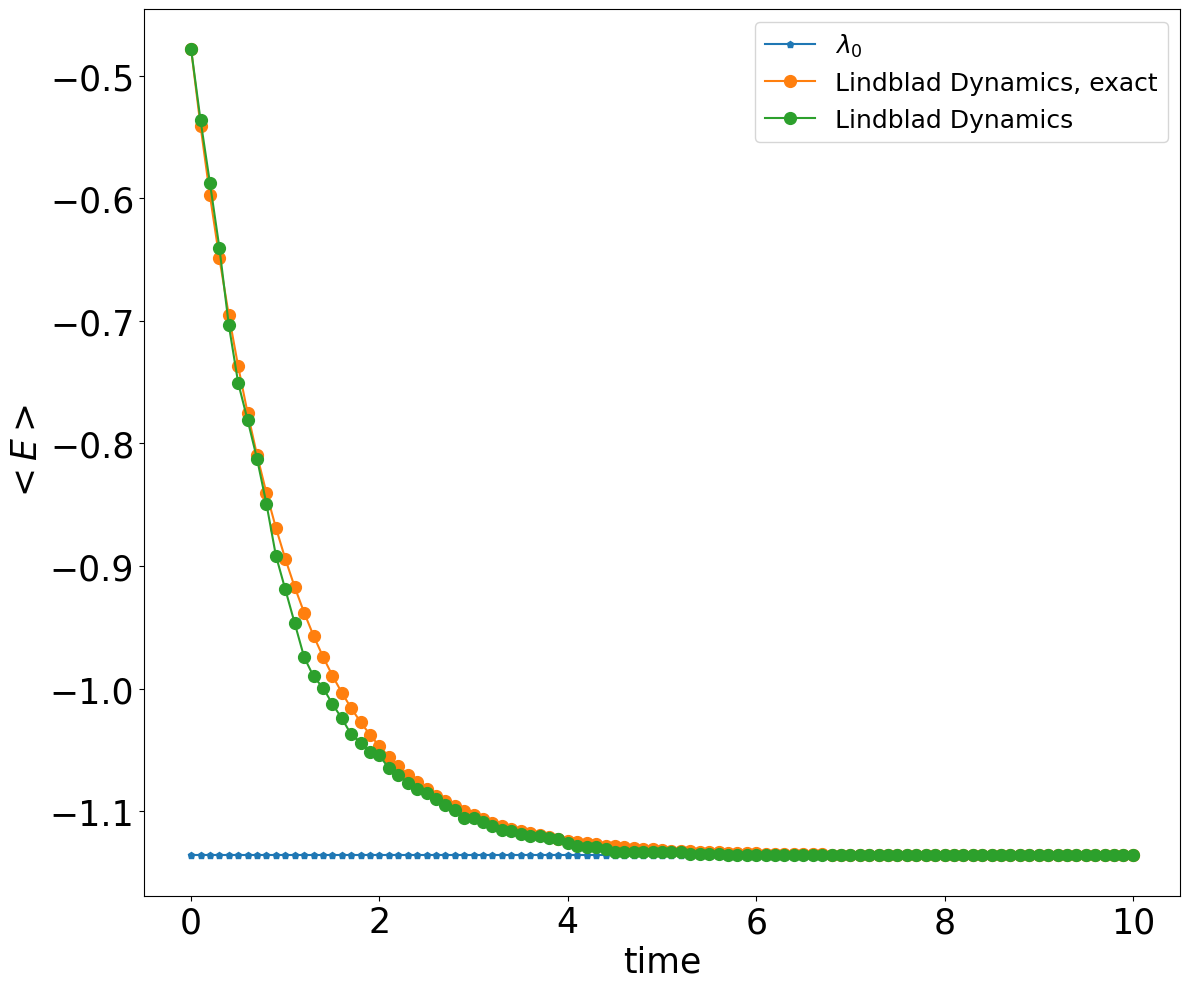

In [71]:


times = [dt*k for k in range(int(T/dt+1))]



chemaccu = 1.6*1e-3
plt.figure(figsize=(12,10))
plt.plot(times, [E_GS]*len(times), 'p-', label=r'$\lambda_0$', linewidth=1.5,markersize=5)
plt.plot(times, energy_exact,'-o', label=r'Lindblad Dynamics, exact',  linewidth=1.5, markersize=8.5)
plt.plot(times, energy_disc,'-o', label=r'Lindblad Dynamics',  linewidth=1.5, markersize=8.5)
plt.legend(fontsize=18)
plt.xlabel('time',fontsize=25)
plt.ylabel(r'$<E>$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()


